In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [5]:
df = pd.read_csv('/kaggle/input/ipl-dataset-2008-2024/processed_ipl_data2.csv')
df.head()


<ipython-input-5-0a88a8c65201>:1: DtypeWarning: Columns (18,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/ipl-dataset-2008-2024/processed_ipl_data2.csv')


,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,...,method,umpire1,umpire2,is_legal,legal_ball,all_balls_over_ball,adjusted_over_ball,match_number_of_that_season,matches_in_that_season,match_number_in_total
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,...,Normal,Asad Rauf,RE Koertzen,True,1,0.1,0.1,1,58,1
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,...,Normal,Asad Rauf,RE Koertzen,True,2,0.2,0.2,1,58,1
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,...,Normal,Asad Rauf,RE Koertzen,False,2,0.3,0.2,1,58,1
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,...,Normal,Asad Rauf,RE Koertzen,True,3,0.4,0.3,1,58,1
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,...,Normal,Asad Rauf,RE Koertzen,True,4,0.5,0.4,1,58,1


In [6]:
# Fill missing values if any
df['city'] = df['city'].fillna('Unknown')
df['venue'] = df['venue'].fillna('Unknown')
df['winner'] = df['winner'].fillna('No Result')  # optional

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df['season'] = df['date'].dt.year


In [31]:
match_df = df.drop_duplicates(subset='match_id', keep='first')


In [32]:
features = [
    'team1', 'team2', 'venue', 'city', 'season',
    'toss_winner', 'toss_decision',
    'is_home_team', 'toss_is_batting',
    'team1_win_count', 'team2_win_count'
]

target = 'winner'

In [ ]:
X = match_df[features].copy()
y = match_df[target].copy()

In [37]:
# Step 3: Select feature matrix and target
X = match_df[features].copy()
y = match_df[target].copy()

# Step 4: Fill missing values
X.fillna('Unknown', inplace=True)
y.fillna('Unknown', inplace=True)  # Move this before encoding

# Step 5: Label Encoding
le_dict = {}
for col in X.columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    le_dict[col] = le  # Save for inverse transform

# Encode target
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'SVM (Linear)': SVC(kernel='linear')
}


In [44]:

print("Model Accuracy Comparison:")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: {acc:.4f}")

Model Accuracy Comparison:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: 0.2511
Random Forest: 0.4566
XGBoost: 0.5388
Gradient Boosting: 0.4977
K-Nearest Neighbors: 0.1735
SVM (Linear): 0.3151


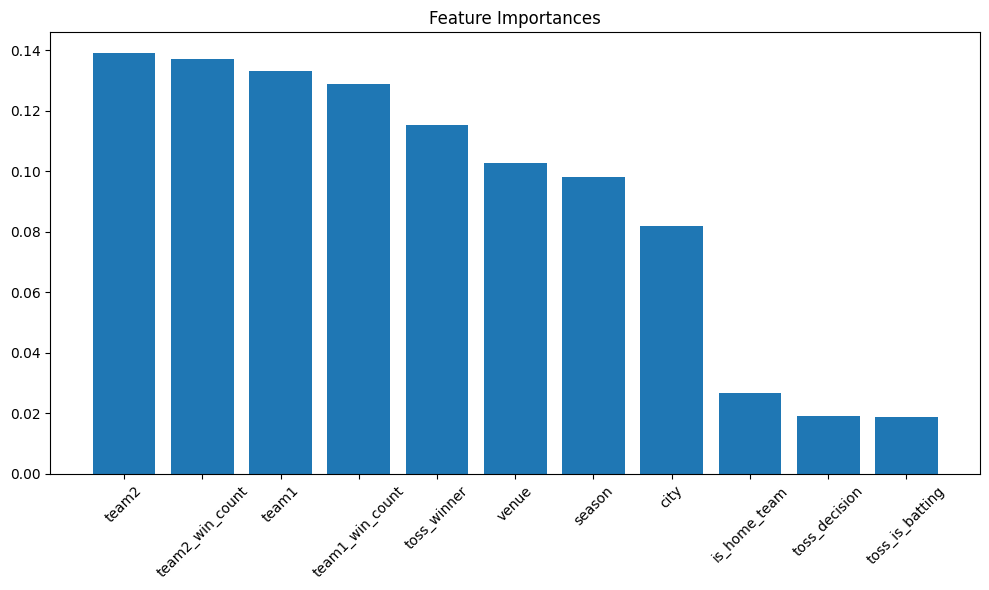

In [40]:
importances = clf.feature_importances_
indices = sorted(range(len(importances)), key=lambda k: importances[k], reverse=True)
labels = [X.columns[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(indices)), [importances[i] for i in indices], align="center")
plt.xticks(range(len(indices)), labels, rotation=45)
plt.tight_layout()
plt.show()

In [46]:
leakage_cols = [
    'match_id', 'id', 'player_of_match', 'winner', 'result', 'result_margin', 
    'date', 'umpire1', 'umpire2', 'match_number', 'match_number_in_total'
]

# Only keep columns that exist in X
leakage_cols_in_X = [col for col in leakage_cols if col in X.columns]

X.drop(columns=leakage_cols_in_X, inplace=True)



In [47]:
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].fillna("Unknown")
    X[col] = LabelEncoder().fit_transform(X[col])


In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [51]:
model = XGBClassifier(n_estimators=150, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Improved XGBoost Accuracy:", accuracy_score(y_test, y_pred))


Improved XGBoost Accuracy: 0.5205479452054794


In [57]:
X_fe = X.copy()

# 1. Encode categorical variables
label_cols = ['team1', 'team2', 'venue', 'city', 'season', 'toss_winner', 'toss_decision']
le_dict = {}
for col in label_cols:
    le = LabelEncoder()
    X_fe[col] = le.fit_transform(X_fe[col])
    le_dict[col] = le


In [61]:
df['is_home_team'] = (
    df.apply(lambda x: 1 if x['team1'] in x['venue'] or x['team2'] in x['venue'] else 0, axis=1)
)
X_fe['team1_win_count'] = X_fe['team1_win_count'].astype(int)
X_fe['team2_win_count'] = X_fe['team2_win_count'].astype(int)
X_fe['team_pair_encoded'] = X['team1'].astype(str) + "_vs_" + X['team2'].astype(str)
le = LabelEncoder()
X_fe['team_pair_encoded'] = le.fit_transform(X_fe['team_pair_encoded'])


In [62]:

X_train, X_test, y_train, y_test = train_test_split(X_fe, y, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Improved XGBoost Accuracy with engineered features: {accuracy:.4f}")

Improved XGBoost Accuracy with engineered features: 0.5160
